In [ ]:

# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

!pip install pyspark

pyspark

     |████████████████████████████████| 281.3 MB 39 kB/s 
     |████████████████████████████████| 198 kB 59.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=d698d1d148a88c6222b50909dedca84d99c0d20f2a912ca9c069a63e4c2ce470
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


<module 'pyspark' from '/content/spark-3.0.0-bin-hadoop3.2/python/pyspark/__init__.py'>

In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkContext 
# sc = SparkContext.getOrCreate() 
spark = SparkSession.builder.appName("DataFrame").getOrCreate()
df_games = spark.read.format("json").load("/content/gdrive/MyDrive/games_2012_copy.json")
df_games.printSchema()     

root
 |-- date: string (nullable = true)
 |-- defense_interception_touchdowns: long (nullable = true)
 |-- defense_interception_yards: long (nullable = true)
 |-- defense_interceptions: long (nullable = true)
 |-- defense_sacks: double (nullable = true)
 |-- defense_safeties: long (nullable = true)
 |-- defense_tackle_assists: long (nullable = true)
 |-- defense_tackles: long (nullable = true)
 |-- field_goal_attempts: long (nullable = true)
 |-- field_goal_makes: long (nullable = true)
 |-- game_location: string (nullable = true)
 |-- game_number: string (nullable = true)
 |-- game_won: boolean (nullable = true)
 |-- kick_return_attempts: long (nullable = true)
 |-- kick_return_touchdowns: long (nullable = true)
 |-- kick_return_yards: long (nullable = true)
 |-- opponent: string (nullable = true)
 |-- opponent_goals: long (nullable = true)
 |-- opponent_goalsage: long (nullable = true)
 |-- opponent_goalsdate: long (nullable = true)
 |-- opponent_score: string (nullable = true)
 |-- 

In [ ]:

from pyspark.sql import SparkSession
from pyspark import SparkContext 
# sc = SparkContext.getOrCreate() 
spark = SparkSession.builder.appName("DataFrame").getOrCreate()

if __name__ == "__main__":
  print("Reading Dataset from the Google Drive storage")
  df_profiles = spark.read.format("json").load("/content/gdrive/MyDrive/profiles.json")
  df_games = spark.read.format("json").load("/content/gdrive/MyDrive/games_2012_copy.json")
  print('Players dataset schema')
  df_profiles.printSchema()
  print('Games dataset schema')
  df_games.printSchema()
  total=df_games.schema.names
  fixed_schema=["age","player_id","year","date","game_number","team","game_location","opponent","game_won","player_team_score","opponent_score","passing_attempts","passing_completions","passing_yards","passing_rating","passing_touchdowns","passing_interceptions","passing_sacks","passing_sacks_yards_lost","rushing_attempts","rushing_yards","rushing_touchdowns","receiving_targets","receiving_receptions","receiving_yards","receiving_touchdowns","kick_return_attempts","kick_return_yards","kick_return_touchdowns","punt_return_attempts","punt_return_yards","punt_return_touchdowns","defense_sacks","defense_tackles","defense_tackle_assists","defense_interceptions","defense_interception_yards","defense_interception_touchdowns","defense_safeties","point_after_attemps","point_after_makes","field_goal_attempts","field_goal_makes","punting_attempts","punting_yards","punting_blocked"]	
  total_schema=df_games.schema.names

  required = ["player_id","team","year","game_number"]
    
  agg_type = ["sum"]   
  extra_fields = [x for x in total_schema if not x in fixed_schema]
  print("extra fields are: ",extra_fields)
  if len(extra_fields)!=0:
    #check if agg_type are given for added columns
    if len(agg_type)!=0:
      #create part of sql query required to find last value or adding agg type 
      last_value_columns=[''+agg+'('+s +') OVER w AS ' +s for agg, s in zip(agg_type,extra_fields)]
			# print(last_value_columns)
    else:
      last_value_columns=['LAST_VALUE('+s +') OVER w AS ' +s for s in extra_fields]
    # print(last_value_columns)
  else:
    #otherwise last value columns will be empty
    last_value_columns=[]
    print(last_value_columns)
  extra_fields = [x for x in total_schema if not x in fixed_schema]
  print("extra fields are: ",extra_fields)

  df_games.createOrReplaceTempView("table_with_extra_columns")

  if len(extra_fields)!=0:
      query = 'select '+',' .join(last_value_columns) +','+ ','  .join(total) + \
            ' FROM table_with_extra_columns WINDOW w AS (partition BY ' + \
          ','.join(required) + ') ORDER BY (' + ','.join(required) + ')'
      print("Generating the Query: ",query)
  else:
      query = 'select ' + ','  .join(total) + \
            ' FROM table_with_extra_columns WINDOW w AS (partition BY ' + \
          ','.join(required) + ') ORDER BY (' + ','.join(required) + ')'
      print("Generating the Query: ",query)

  df_final= spark.sql(query).distinct()
  print("Execute the SQL query Generated")
  print("Finally writing the output to the google drive")

  df_final = df_final.write.format("json").mode("append").option("mergeSchema","true").save("/content/gdrive/MyDrive/NFL_data")  



Reading Dataset from the Google Drive storage
Players dataset schema
root
 |-- birth_date: string (nullable = true)
 |-- birth_place: string (nullable = true)
 |-- college: string (nullable = true)
 |-- current_salary: string (nullable = true)
 |-- current_team: string (nullable = true)
 |-- death_date: string (nullable = true)
 |-- draft_position: string (nullable = true)
 |-- draft_round: string (nullable = true)
 |-- draft_team: string (nullable = true)
 |-- draft_year: string (nullable = true)
 |-- height: string (nullable = true)
 |-- high_school: string (nullable = true)
 |-- hof_induction_year: string (nullable = true)
 |-- name: string (nullable = true)
 |-- player_id: long (nullable = true)
 |-- position: string (nullable = true)
 |-- weight: string (nullable = true)

Games dataset schema
root
 |-- date: string (nullable = true)
 |-- defense_interception_touchdowns: long (nullable = true)
 |-- defense_interception_yards: long (nullable = true)
 |-- defense_interceptions: long 

AnalysisException: ignored

In [ ]:
#changing games data
from pyspark.sql.functions import lit
df = spark.read.format('json').option("inferSchema", "true").option("header", "true").load('/content/gdrive/MyDrive/games_delta_table')
df = df.withColumn("opponent_goals",lit(50)).write.format('json').mode("overwrite").option("inferSchema", "true")
                              .option("header", "true").save('/content/gdrive/MyDrive/games_2012_copy.json')

IndentationError: ignored

In [ ]:
#Find average weight of the players
df = spark.read.format('json').load('/content/gdrive/MyDrive/profiles.json')
df.createOrReplaceTempView('player_weight')
df = spark.sql('select ROUND(avg(weight),3) as avg_weight from player_weight').show()


+----------+
|avg_weight|
+----------+
|   225.225|
+----------+



In [ ]:
#game_location
from pyspark.sql.functions import when
df_games = spark.read.format("json").load("/content/gdrive/MyDrive/games_2012_copy.json")
df_games.createOrReplaceTempView('df_games')

df = spark.sql('select game_location, count(game_location) as games_played,year from df_games where year="2012" group by game_location')

df_games_played = df.withColumn("game_location", when(df.game_location == "N","NRG Stadium, Houston")
                                 .when(df.game_location == "H","Hawaii")
                                 .when(df.game_location == "A","Arizona")
                                 .when(df.game_location.isNull() ,"")
                                 .otherwise(df.game_location))
# df_games_played.show()


AnalysisException: ignored

([<matplotlib.patches.Wedge at 0x7efe6e4e4b50>,
 [Text(-0.7116212008212093, -0.8388058574794172, 'Arizona'),
  Text(0.8421673506380203, -0.7076398473230137, 'NRG Stadium, Houston'),
  Text(0.7030668628350684, 0.8459887625632242, 'Hawaii')],
 [Text(-0.38815701862975044, -0.45753046771604566, '49.8%'),
  Text(0.4593640094389201, -0.38598537126709836, '0.3%'),
  Text(0.38349101609185543, 0.4614484159435768, '49.8%')])

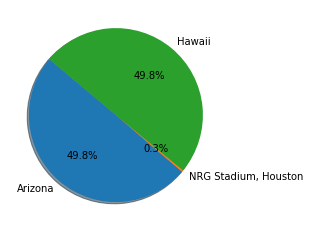

In [ ]:
import matplotlib.pyplot as plt

game_location1 = [val.game_location for val in df_games_played.select('game_location').collect()]
games_played1 = [val.games_played for val in df_games_played.select('games_played').collect()]




from matplotlib import pyplot as plt
import numpy as np
 
plt.pie(games_played1, labels=game_location1,
autopct='%1.1f%%', shadow=True, startangle=140)


# plt.bar(game_location1,games_played1)

# plt.xlabel('game_location1')
# plt.ylabel('games_played1')
# plt.title('games_played1 vs game_location1')
# #plt.legend(['current_salary'], loc='upper left')
# #need to use pie chart

# plt.show()

In [ ]:
# salary 
df = spark.read.format('json').load('/content/gdrive/MyDrive/profiles.json')
# df.select('current_salary').show()
# df.select('name','current_salary').filter('current_salary is not null').sort(('current_salary').desc()).show()
df.createOrReplaceTempView('df_salary')
df_salary = spark.sql("select REPLACE(current_salary, ',', '') AS current_salary,name,position from df_salary order by current_salary desc limit 10")#.show()
# position vs salary



In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

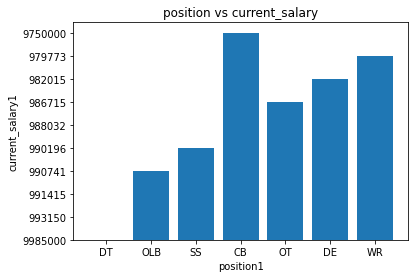

In [ ]:
import matplotlib.pyplot as plt

current_salary1 = [val.current_salary for val in df_salary.select('current_salary').collect()]
position1= [val.position for val in df_salary.select('position').collect()]


plt.bar(position1, current_salary1) 

plt.ylabel('current_salary1')
plt.xlabel('position1')
plt.title('position vs current_salary')

plt.show()

In [ ]:
#Winning team

from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark import SparkContext 
# sc = SparkContext.getOrCreate() 
spark = SparkSession.builder.appName("DataFrame").getOrCreate()
df_games = spark.read.format("json").load("/content/gdrive/MyDrive/games_2012_copy.json")

df_games = df_games.select('game_won','team').filter("game_won ='true'").filter("year = 2013")
df_games.createOrReplaceTempView("df_games")

df_won = spark.sql('select count(team) as win_team,team from df_games group by game_won,team limit 10').orderBy(col("win_team").desc())#.show()

ModuleNotFoundError: ignored

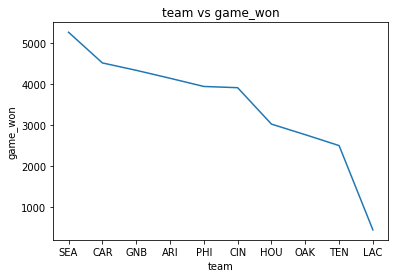

In [ ]:
import matplotlib.pyplot as plt

game_won1 = [val.win_team for val in df_won.select('win_team').collect()]
team1 = [val.team for val in df_won.select('team').collect()]

plt.plot(team1, game_won1)

plt.ylabel('game_won')
plt.xlabel('team')
plt.title('team vs game_won')
#plt.legend(['current_salary'], loc='upper left')

plt.show()

Text(0.5, 1.0, 'college vs draft_round')

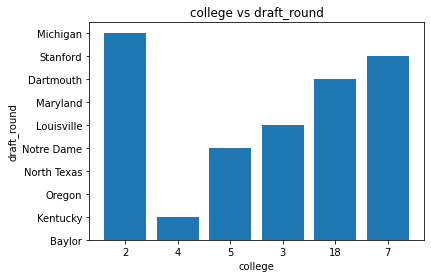

In [ ]:
# we need to write pyspark code for this below line
df_draft_round = spark.read.format('json').load('/content/gdrive/MyDrive/profiles.json')
df_draft_round = df_draft_round.select('college','draft_round')
df_draft_round.createOrReplaceTempView('df_draft_round')
df_draft_round = spark.sql('select * from df_draft_round where college is not null and draft_round is not null limit 10')
# player_stats = df[['college','draft_round']]
# player_stats.head(10)
college1 = [val.college for val in df_draft_round.select('college').collect()]
draft_round1 = [val.draft_round for val in df_draft_round.select('draft_round').collect()]
# plt.bar(list(player_stats['college'])[0:10],list(player_stats['draft_round'])[0:10],color=["blue","red","green","pink","yellow"])

plt.bar(draft_round1,college1 ) 

plt.ylabel('draft_round')
plt.xlabel('college')
plt.title('college vs draft_round')

In [ ]:
# importing neccessary libraries
# Pandas is a library use for data manipulation and analysis
import pandas as DataFrame
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
# Reading the profile dataset
df = pd.read_json('/content/gdrive/MyDrive/profiles.json')
df.head(5)
df.dtypes


player_id               int64
name                   object
position               object
height                 object
weight                float64
current_team           object
birth_date             object
birth_place            object
death_date             object
college                object
high_school            object
draft_team             object
draft_round           float64
draft_position        float64
draft_year            float64
current_salary         object
hof_induction_year    float64
dtype: object

In [ ]:
df.describe()

player_id        weight  ...    draft_year  hof_induction_year
count  25043.000000  24927.000000  ...  15041.000000                 0.0
mean   12522.000000    225.225298  ...   1983.006781                 NaN
std     7229.435732     39.319806  ...     21.269571                 NaN
min        1.000000    119.000000  ...   1936.000000                 NaN
25%     6261.500000    195.000000  ...   1968.000000                 NaN
50%    12522.000000    217.000000  ...   1984.000000                 NaN
75%    18782.500000    250.000000  ...   2001.000000                 NaN
max    25043.000000    376.000000  ...   2017.000000                 NaN

[8 rows x 6 columns]

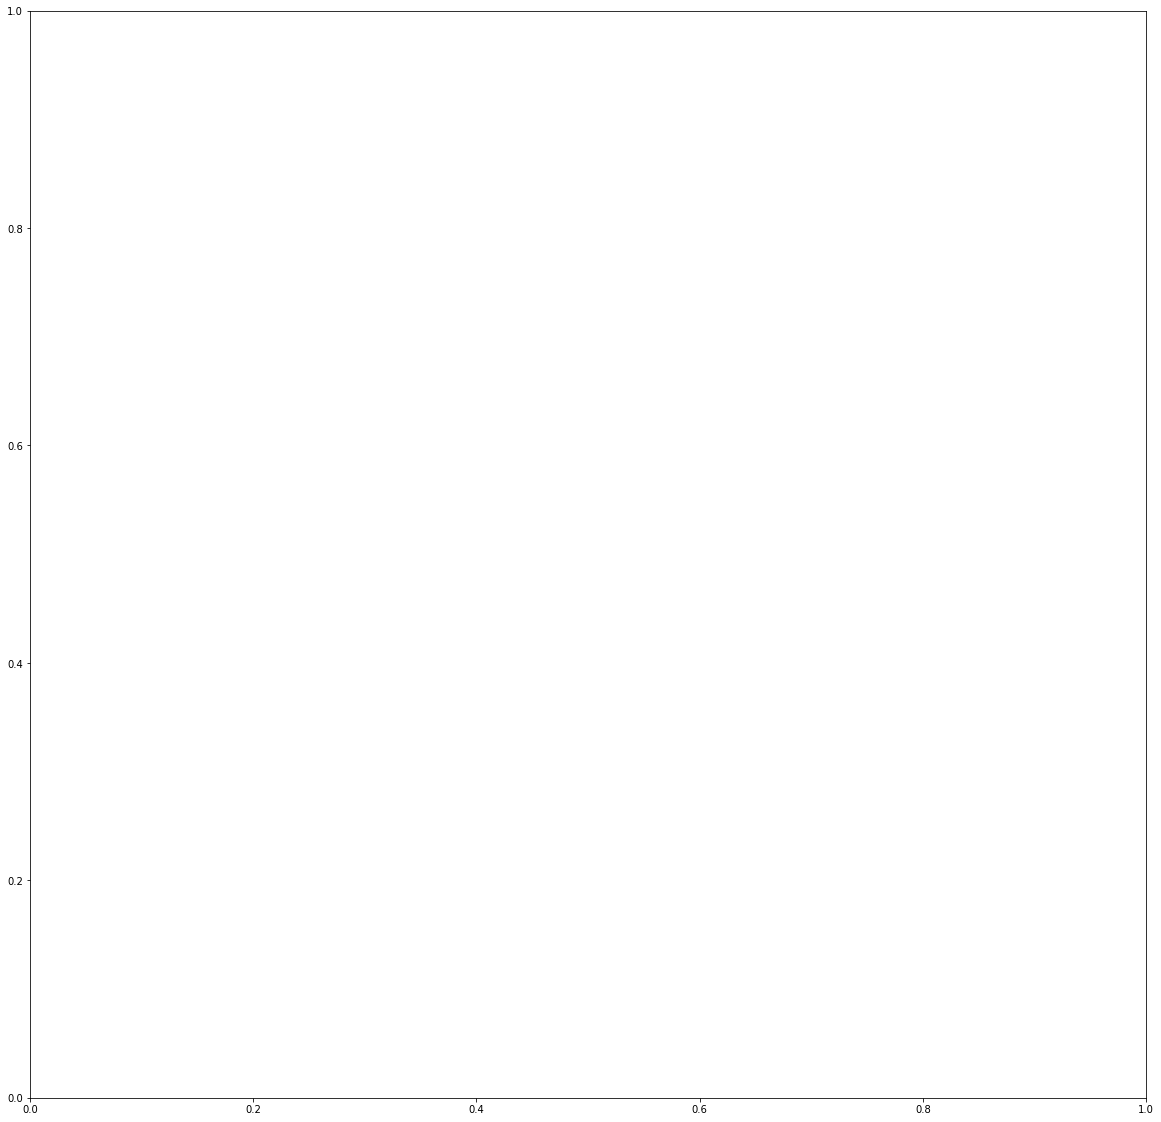

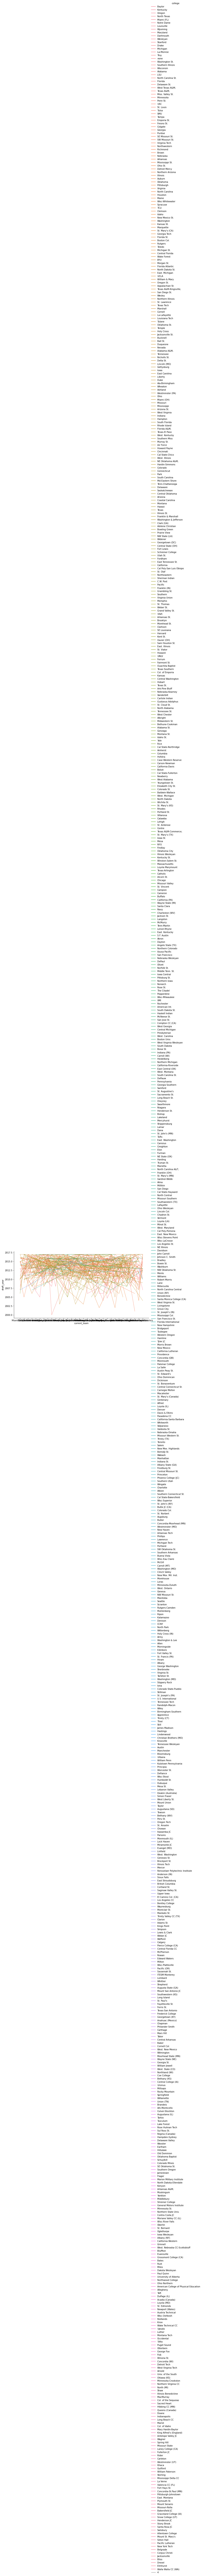

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
ax = sns.relplot(x="current_team", y="draft_year", kind="line", hue='college', ci=None, data=df, size=4, aspect = 2)
ax.set(xlabel='current_team', ylabel = 'draft_year')
plt.show()

In [ ]:
# shows the categorical columns from dataset
categorical_columns = df.select_dtypes(['object']).columns
print(categorical_columns)
# Applying the label encoder to the categoriacal columns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
label_encoder = preprocessing.LabelEncoder()
for col in df[categorical_columns]:
    df[col]= label_encoder.fit_transform(df[col])
print(df)
#df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(999, inplace=True)
# Identify the dependent and independent variables from the dataset
X = df.drop('draft_round',axis=1)
y = df['draft_round']
# Split the dataset into the training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# Feature Scaling is a method used to standardize the range of features of data.
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


Index(['name', 'position', 'height', 'current_team', 'birth_date',
       'birth_place', 'death_date', 'college', 'high_school', 'draft_team',
       'current_salary'],
      dtype='object')
       player_id   name  ...  current_salary  hof_induction_year
0           1809  19555  ...             478                 NaN
1          23586   6083  ...             478                 NaN
2            355  14451  ...              10                 NaN
3          18182  21370  ...             478                 NaN
4          16250   4844  ...             478                 NaN
...          ...    ...  ...             ...                 ...
25038      17925   8194  ...             478                 NaN
25039      10762   7638  ...             478                 NaN
25040      19343  19963  ...             478                 NaN
25041       4880   5456  ...             478                 NaN
25042      23865  23689  ...             478                 NaN

[25043 rows x 17 columns]


In [ ]:
# Training the Support Vector Machine model on the training set.
# To implement the Support Vector Machines we will use Scikit-learn and will import our SVM
from sklearn.svm import LinearSVC
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import r2_score
# Create SVM model. We are using Linear SVC.
clf = LinearSVC(random_state=0, tol=1e-5)
# fit() function allows us to train the model, adjusting weights according to the data values in order ti achieve better accuracy.
clf.fit(X_train, y_train.ravel())
# Pridicting the test set results
y_pred_class = clf.predict(X_test)
print("predicted values are :\n",y_pred_class)
#Create confusion Matrix
Confusion_matrix_SVM = confusion_matrix(y_test, y_pred_class)
print("Confusion Matrix:\n", Confusion_matrix_SVM)
# Import scikit-learn metrics module for accuracy calculation.
classification_SVM = metrics.classification_report(y_test, y_pred_class)
print("Classification Report of SVM model is:\n", classification_SVM)
# Accuracy of svc model
Accuracy_SVM = metrics.accuracy_score(y_test,y_pred_class)
print("Accuracy of SVM model is:", Accuracy_SVM)
# R2 score assess the accuracy of our model
SVM_r2_score = r2_score(y_test, y_pred_class)
print("R2 score of SVM model is:", SVM_r2_score)

predicted values are :
 [  3. 999.   6. ...   7.   4. 999.]
Confusion Matrix:
 [[ 407    0    0 ...    0    0    0]
 [ 104  205    6 ...    0    0    0]
 [  20  194  110 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 2014]]
Classification Report of SVM model is:
               precision    recall  f1-score   support

         1.0       0.76      1.00      0.86       407
         2.0       0.44      0.65      0.53       315
         3.0       0.20      0.34      0.25       324
         4.0       0.40      0.13      0.20       354
         5.0       0.23      0.06      0.09       301
         6.0       0.31      0.17      0.22       293
         7.0       0.23      0.77      0.35       288
         8.0       0.02      0.01      0.01       130
         9.0       0.17      0.01      0.02       104
        10.0       0.00      0.00      0.00        89
        11.0       0.00      0.00      0.00        71
    

Confusion Matrix:
 [[ 407    0    0 ...    0    0    0]
 [ 104  205    6 ...    0    0    0]
 [  20  194  110 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 2014]]


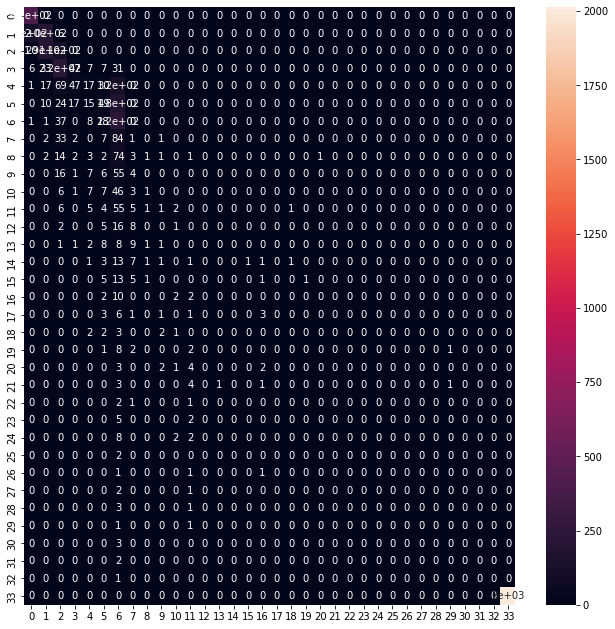

In [ ]:
import seaborn as sns
#import seaborn as sns
Confusion_matrix_SVM = confusion_matrix(y_test, y_pred_class)
print("Confusion Matrix:\n", Confusion_matrix_SVM)
fig, ax = plt.subplots(figsize=(11, 11))
sns.heatmap(Confusion_matrix_SVM, annot=True)

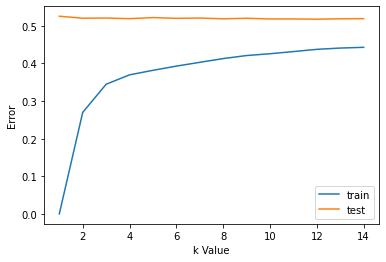

In [ ]:
from sklearn.neighbors import KNeighborsClassifier  
#classifier= KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 )  
#classifier.fit(X_train, y_train)
#Predicting the test set result  
#y_pred= classifier.predict(X_test) 
#print(y_pred)  
error1= []
error2= []
for k in range(1,15):
    knn= KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred1= knn.predict(X_train)
    error1.append(np.mean(y_train!= y_pred1))
    y_pred2= knn.predict(X_test)
    error2.append(np.mean(y_test!= y_pred2))
# plt.figure(figsize(10,5))
plt.plot(range(1,15),error1,label="train")
plt.plot(range(1,15),error2,label="test")
plt.xlabel('k Value')
plt.ylabel('Error')
plt.legend()

In [ ]:
# Import knearest neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
# Setup a knn classifier with k neighbors
# Try K=1 through K=10 and record testing accuracy
k_range = range(3, 9)

# We can create Python dictionary using [] or dict()
scores = []

# We are using a loop through the range 1 to 10
# We can append the scores in the dictionary
for k in k_range:
    # Create KNN Classifier
    Model_knn = KNeighborsClassifier(n_neighbors=k)
    # Train the model using the training sets
    # Fit the model
    Model_knn.fit(X_train, y_train)
    # Predict the response for test dataset
    predKNN = Model_knn.predict(X_test)
    # In case of classification algorithms score method represents an accuracy.
    # Evaluating the test accuracy
    scores.append(metrics.accuracy_score(y_test, predKNN))
print ("Accuracy of KNN model is: \n", scores)

Accuracy of KNN model is: 
 [0.4793371930525055, 0.48093431822719107, 0.4781393491714913, 0.4801357556398483, 0.4793371930525055, 0.48133359952086247]


In [ ]:
classification_KNN = metrics.classification_report(y_test, predKNN)
print("Classification Report of KNN model is:\n", classification_KNN)

Classification Report of KNN model is:
               precision    recall  f1-score   support

         1.0       0.19      0.34      0.24       407
         2.0       0.14      0.24      0.17       315
         3.0       0.12      0.18      0.14       324
         4.0       0.13      0.14      0.13       354
         5.0       0.09      0.09      0.09       301
         6.0       0.10      0.06      0.08       293
         7.0       0.15      0.09      0.12       288
         8.0       0.02      0.01      0.01       130
         9.0       0.05      0.02      0.03       104
        10.0       0.00      0.00      0.00        89
        11.0       0.04      0.01      0.02        71
        12.0       0.07      0.01      0.02        80
        13.0       0.00      0.00      0.00        32
        14.0       0.00      0.00      0.00        31
        15.0       0.00      0.00      0.00        30
        16.0       0.00      0.00      0.00        26
        17.0       0.00      0.00      0.

Text(0, 0.5, 'Testing Accuracy')

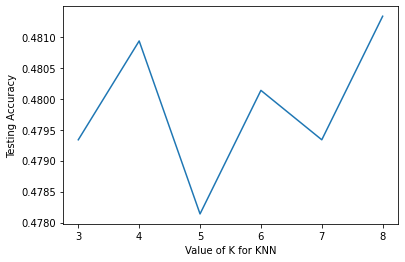

In [ ]:
# Import Matplotlib (scientific plotting library)
import matplotlib.pyplot as plt

# Allow plots to appear within the notebook
%matplotlib inline

# Plot the relationship between K and testing accuracy
# Plt.plot(x_axis, y_axis)
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [ ]:
predKNN

array([  1., 999.,   2., ...,   8.,   2., 999.])

Confusion Matrix:
 [[ 137   82   69 ...    0    0    0]
 [  91   76   50 ...    0    0    0]
 [  88   56   58 ...    0    0    0]
 ...
 [   2    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 2014]]


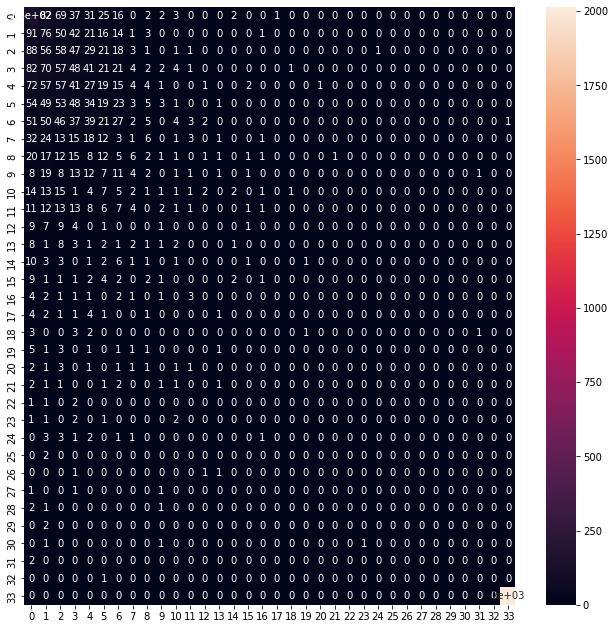

In [ ]:
import seaborn as sns
#import seaborn as sns
Confusion_matrix_KNN = confusion_matrix(y_test, predKNN)
print("Confusion Matrix:\n", Confusion_matrix_KNN)
fig, ax = plt.subplots(figsize=(11, 11))
sns.heatmap(Confusion_matrix_KNN, annot=True)

                    player_id      name  ...  current_salary  hof_induction_year
player_id            1.000000  0.022636  ...        0.005166                 NaN
name                 0.022636  1.000000  ...        0.004723                 NaN
position            -0.004786  0.019450  ...       -0.041400                 NaN
height               0.000024  0.000060  ...       -0.041008                 NaN
weight               0.006296 -0.017914  ...       -0.054027                 NaN
current_team         0.000249  0.009403  ...        0.725943                 NaN
birth_date          -0.011175  0.043489  ...       -0.351299                 NaN
birth_place          0.002968 -0.001275  ...       -0.072555                 NaN
death_date          -0.013535  0.039363  ...       -0.120667                 NaN
college              0.011006  0.002062  ...        0.006914                 NaN
high_school         -0.004207 -0.005733  ...       -0.049276                 NaN
draft_team          -0.00140

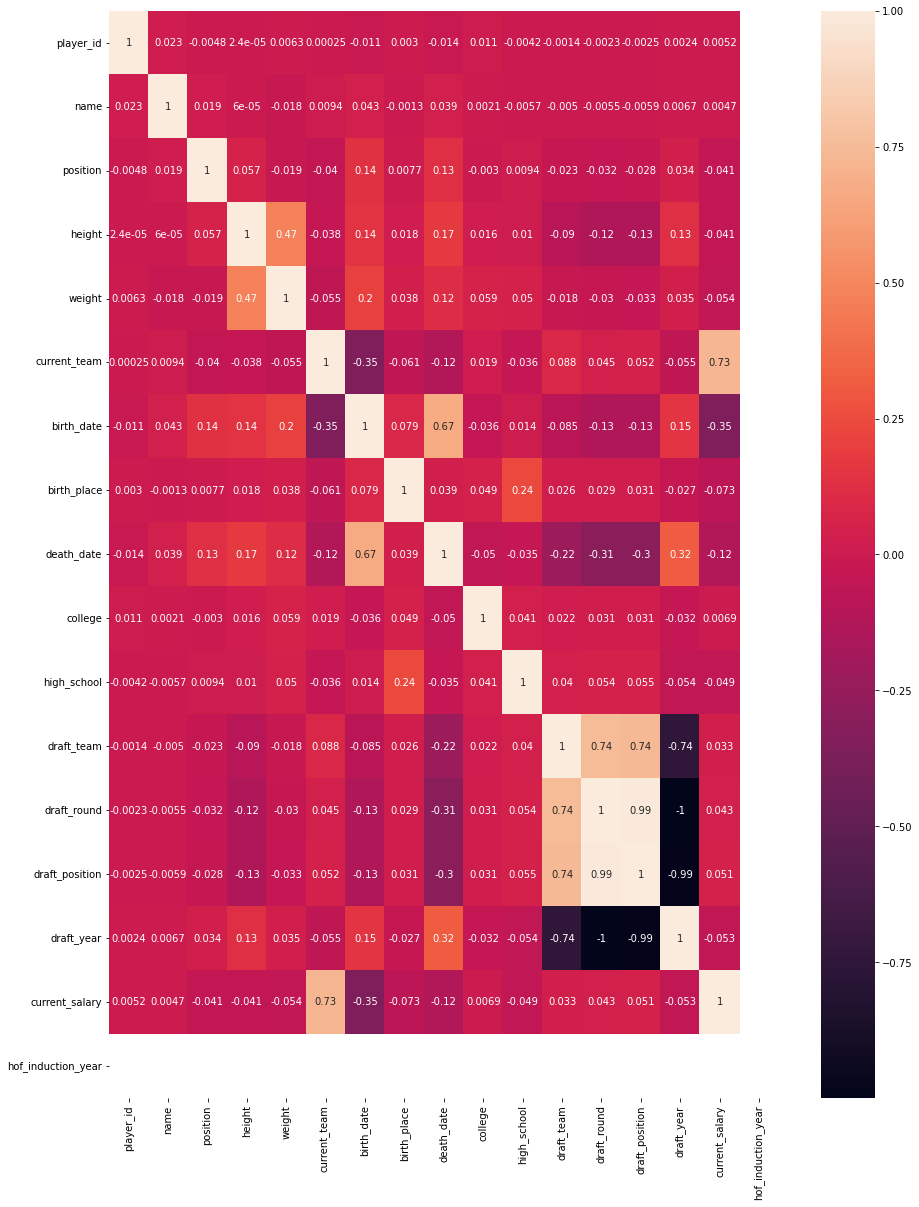

correlation between two columns is: 0.9883085163743526


In [ ]:
#The Correlation method displays the correlation between the features and the target.
#The first 3 features are the most positively correlated with SalePrice, while the next 3 are the most negatively correlated.
import numpy as np
import seaborn as sn
from matplotlib import pyplot as plt
corr = df.corr()
print(corr)
#print ("the top 3 most positively correlated features to the quality is :\n", corr['draft_round'].sort_values(ascending=False)[:16], '\n')
plt.figure(figsize=(15,20))
sn.heatmap(corr, annot=True)
plt.show()
correlation = df["draft_round"].corr(df["draft_position"])
print("correlation between two columns is:",correlation)

In [ ]:
# Used for plotting data
%matplotlib inline
import matplotlib.pyplot as plt

# Used for data storage and manipulation 
import numpy as np
import pandas as pd

# Used for Regression Modelling
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split

# Used for Acc metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# For stepwise regression
import statsmodels.api as sm

# box plots
import seaborn as sns
# pairplot
from seaborn import pairplot
# Correlation plot
from statsmodels.graphics.correlation import plot_corr


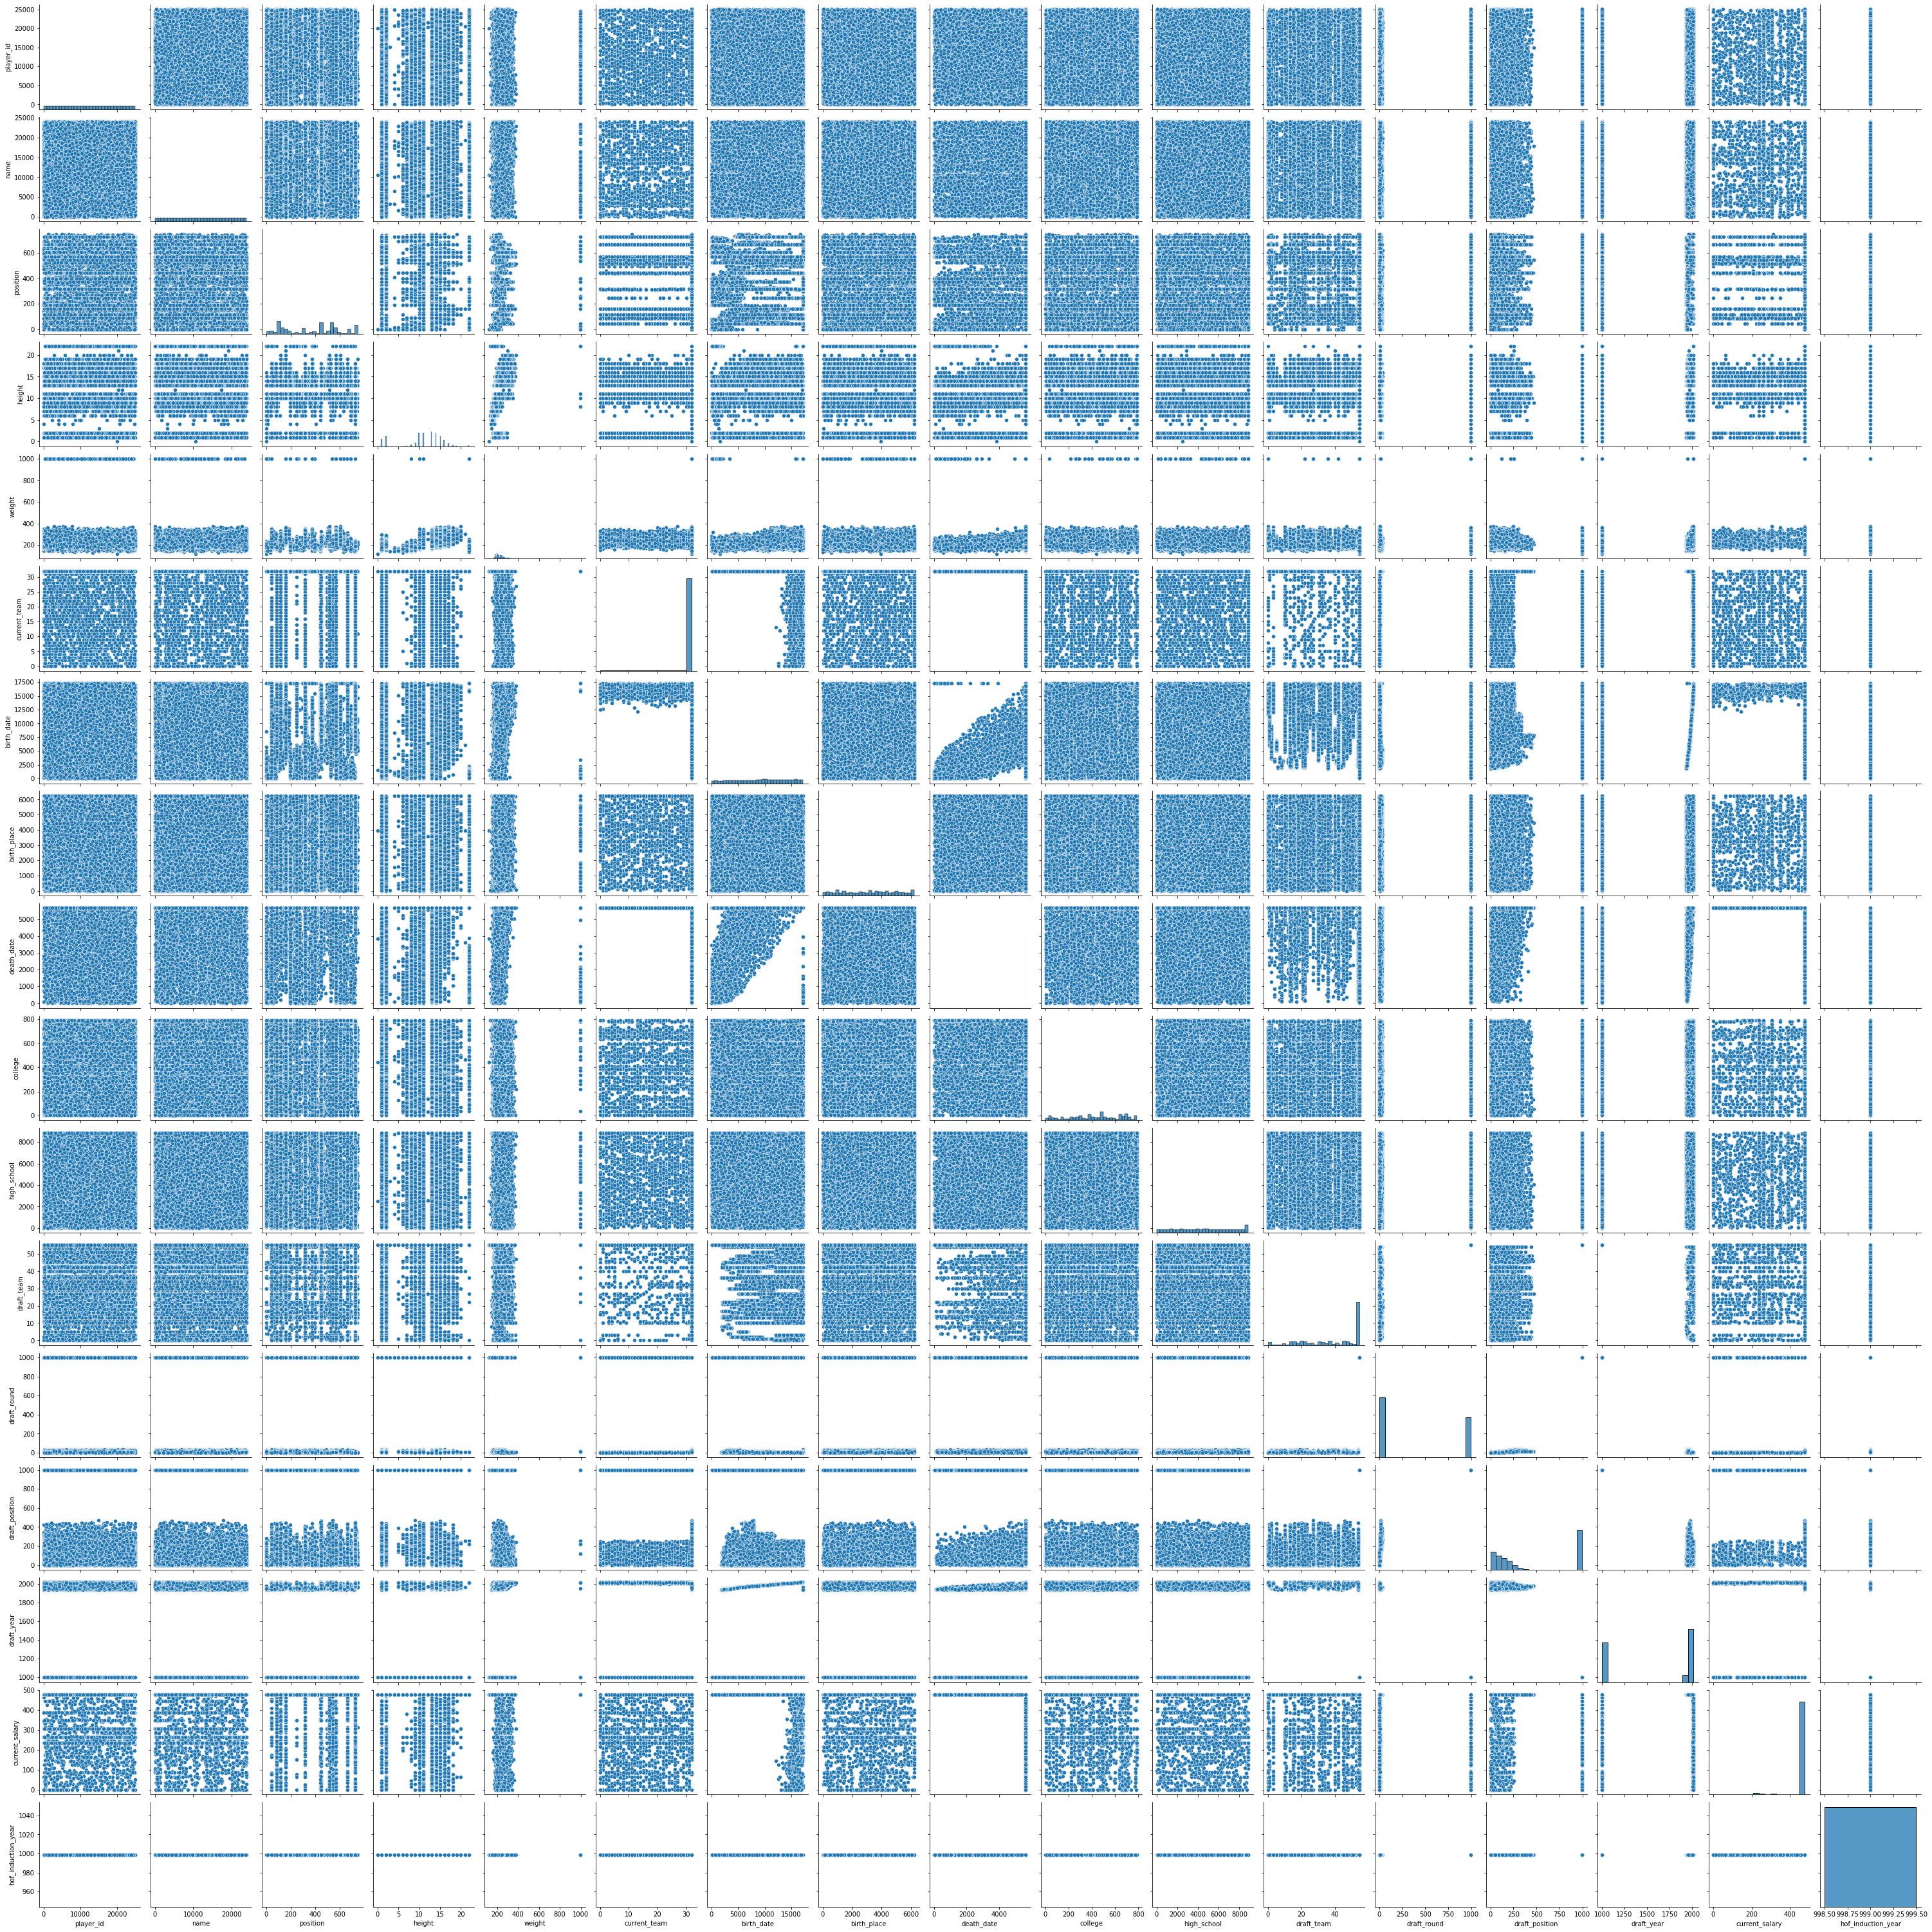

In [ ]:
pairplot(df)

In [ ]:
# importing neccessary libraries
# Pandas is a library use for data manipulation and analysis
import pandas as DataFrame
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
# Reading the profile dataset
df2 = pd.read_json('/content/gdrive/MyDrive/games_2012.json', lines= True)
df2.head(5)
df2.dtypes

age                                        object
date                               datetime64[ns]
defense_interception_touchdowns             int64
defense_interception_yards                  int64
defense_interceptions                       int64
defense_sacks                             float64
defense_safeties                            int64
defense_tackle_assists                      int64
defense_tackles                             int64
field_goal_attempts                         int64
field_goal_makes                            int64
game_location                              object
game_number                                 int64
game_won                                     bool
kick_return_attempts                        int64
kick_return_touchdowns                      int64
kick_return_yards                           int64
opponent                                   object
opponent_score                              int64
passing_attempts                            int64


                                 defense_interception_touchdowns  ...      year
defense_interception_touchdowns                              NaN  ...       NaN
defense_interception_yards                                   NaN  ... -0.004354
defense_interceptions                                        NaN  ... -0.008071
defense_sacks                                                NaN  ... -0.005782
defense_safeties                                             NaN  ...  0.000224
defense_tackle_assists                                       NaN  ... -0.014225
defense_tackles                                              NaN  ... -0.030386
field_goal_attempts                                          NaN  ...  0.001844
field_goal_makes                                             NaN  ...  0.000933
game_number                                                  NaN  ... -0.134126
game_won                                                     NaN  ...  0.000514
kick_return_attempts                    

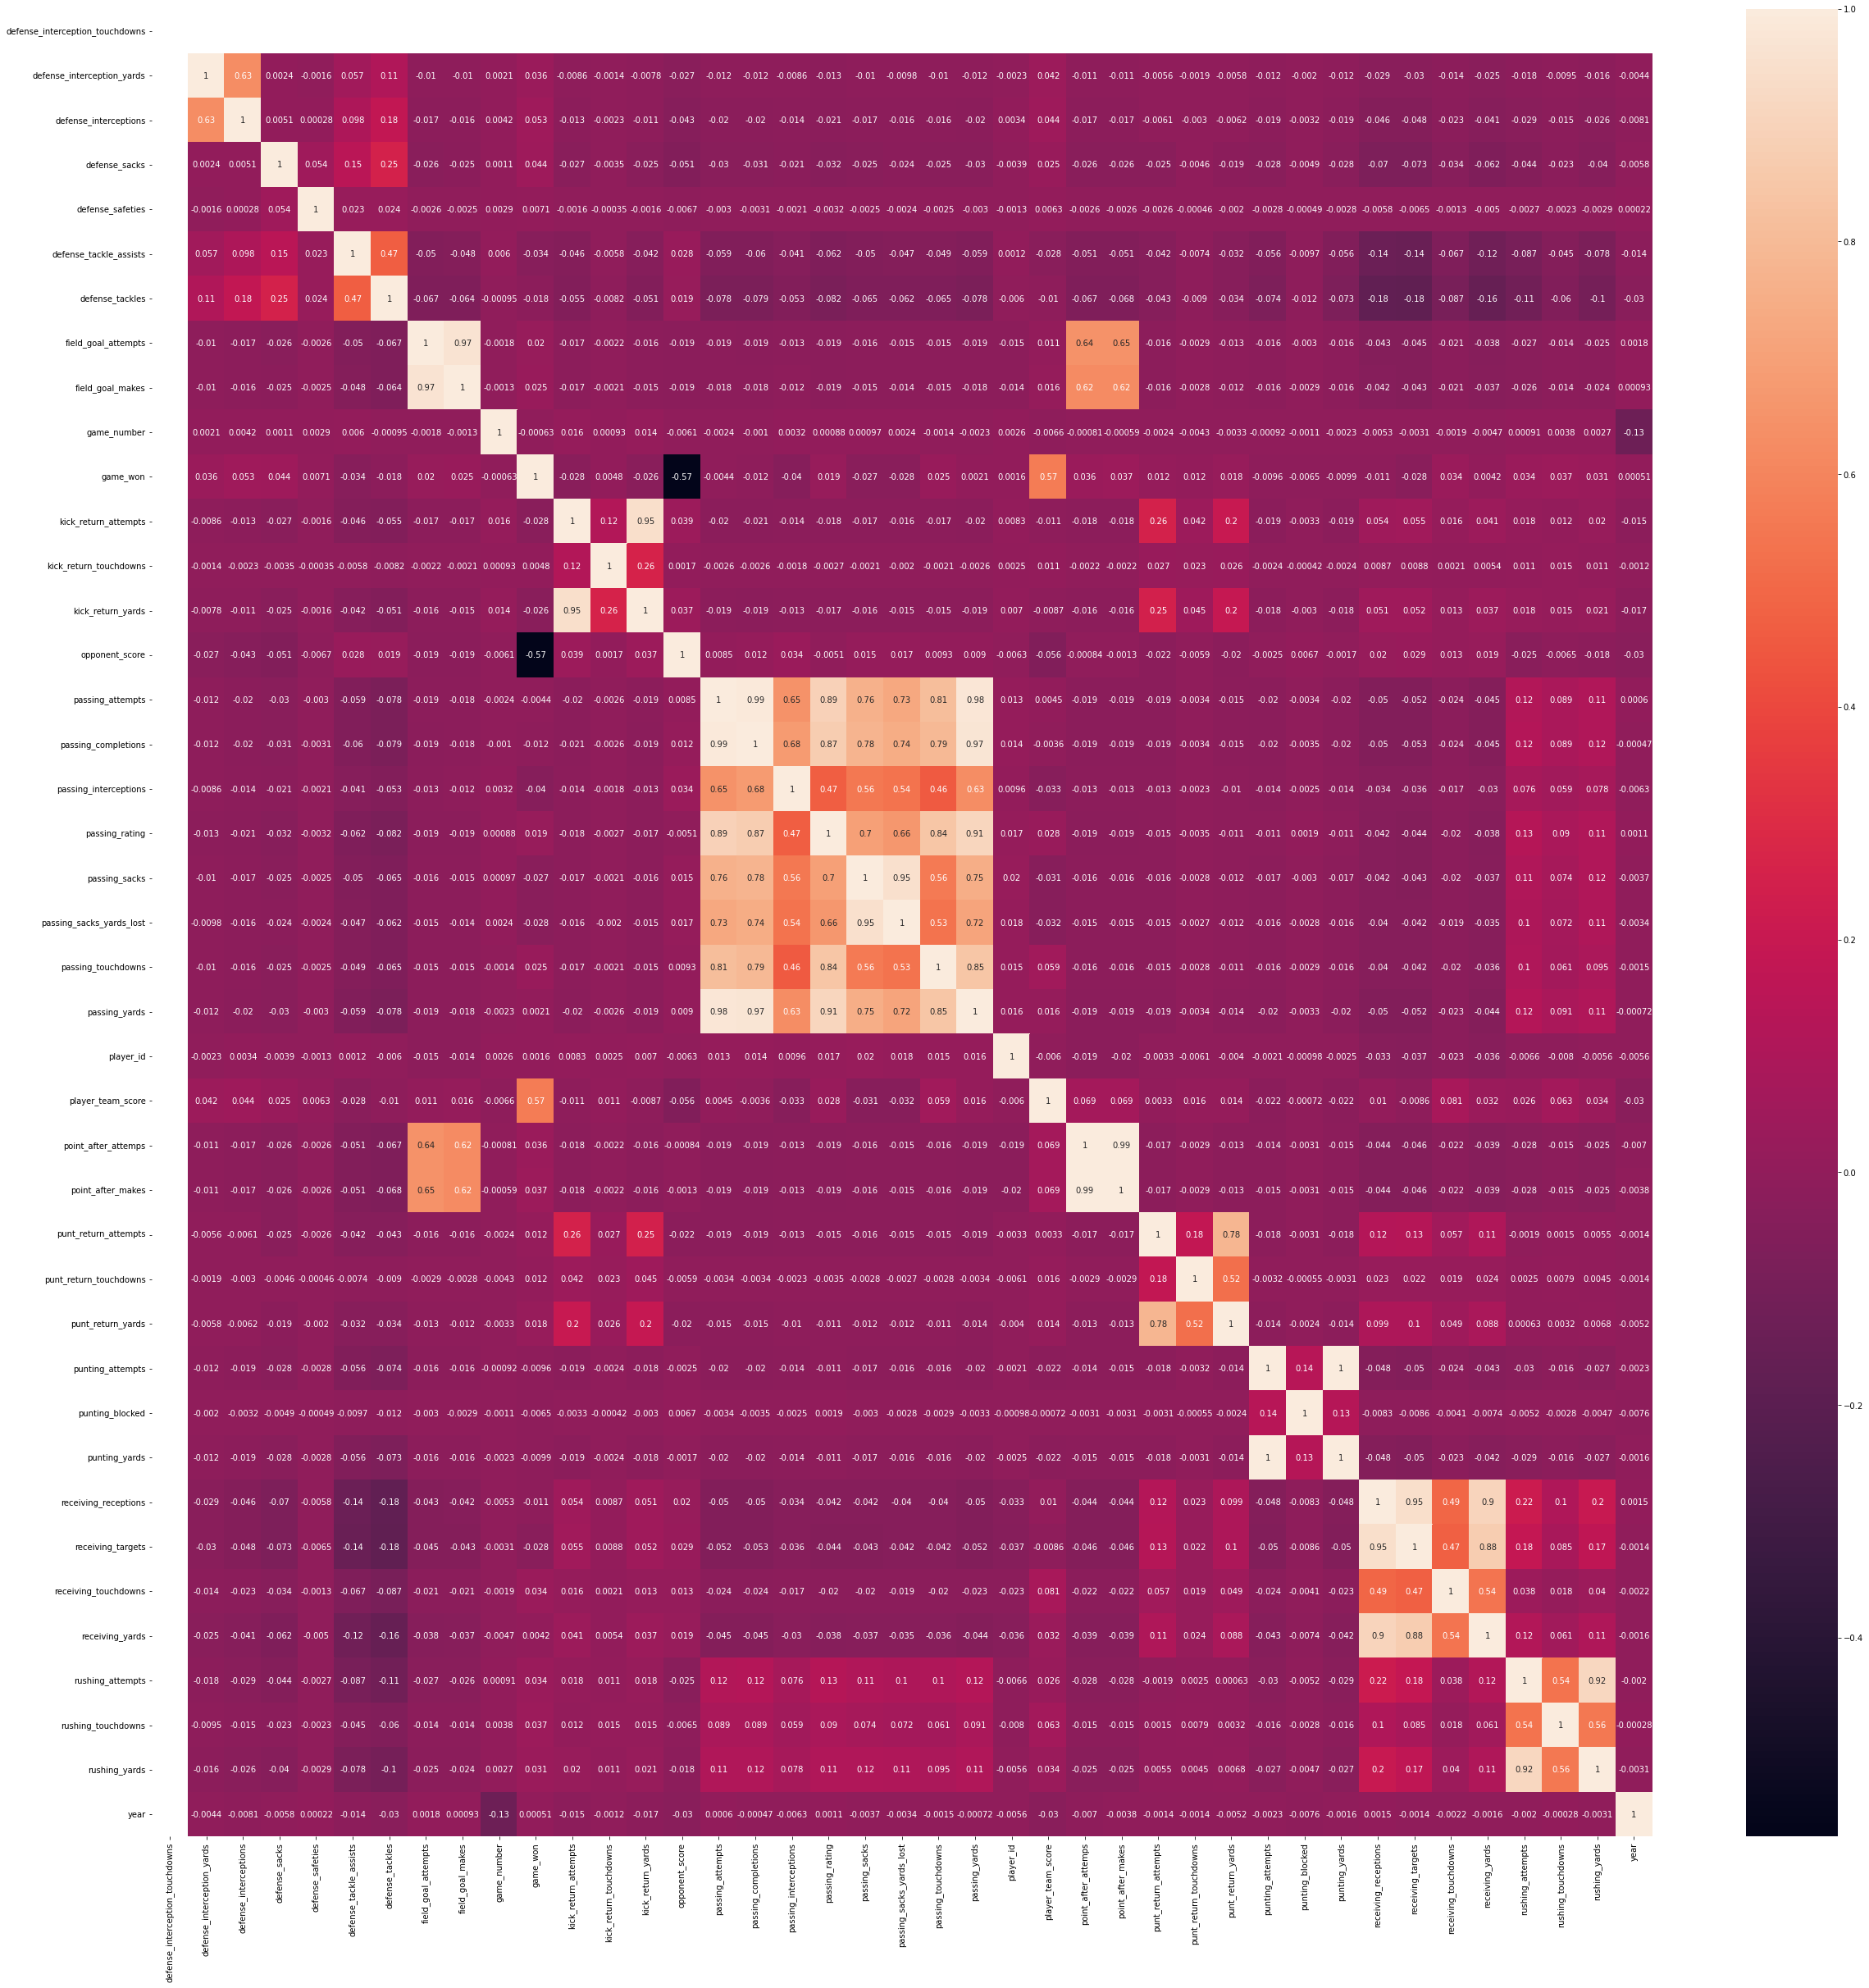

In [ ]:
import numpy as np
import seaborn as sn
from matplotlib import pyplot as plt
corr = df2.corr()
print(corr)
#print ("the top 3 most positively correlated features to the quality is :\n", corr['game_won'].sort_values(ascending=False)[:16], '\n')
plt.figure(figsize=(41,41))
sn.heatmap(corr, annot=True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyspark.sql.functions as F


passing  = [val.current_salary for val in df2.select('passing_interception').collect()]
completions = [val.position for val in df2.select('passing_completions').collect()]


plt.bar(completions, passing) 

plt.ylabel('passing')
plt.xlabel('completions')
plt.title('position vs current_salary')

plt.show()

AttributeError: ignored

In [ ]:
# shows the categorical columns from dataset
categorical_columns = df.select_dtypes(['object']).columns
print(categorical_columns)
# Applying the label encoder to the categoriacal columns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
label_encoder = preprocessing.LabelEncoder()
for col in df2[categorical_columns]:
    df2[col]= label_encoder.fit_transform(df2[col])
print(df2)
df2.replace([np.inf, -np.inf], np.nan, inplace=True)
#df2.fillna(999, inplace=True)
# Identify the dependent and independent variables from the dataset
X = df2.drop('receiving_receptions',axis=1)
y = df2['receiving_receptions']
# Split the dataset into the training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# Feature Scaling is a method used to standardize the range of features of data.
from sklearn.preprocessing import StandardScaler
#sc_X = StandardScaler()
#X_train = sc_X.fit_transform(X_train)
#X_test = sc_X.fit_transform(X_test)
from sklearn.preprocessing import Normalizer
transformer = Normalizer().fit(X_train)
X_train = transformer.transform(X_train)
transformer = Normalizer().fit(X_test)
X_test = transformer.transform(X_test)

Index([], dtype='object')
           age       date  ...  team  year
0       23-025 2013-09-08  ...   BUF  2013
1       23-032 2013-09-15  ...   BUF  2013
2       23-039 2013-09-22  ...   BUF  2013
3       23-046 2013-09-29  ...   BUF  2013
4       23-050 2013-10-03  ...   BUF  2013
...        ...        ...  ...   ...   ...
110751  25-196 2014-09-28  ...   PHI  2014
110752  25-210 2014-10-12  ...   PHI  2014
110753  25-224 2014-10-26  ...   PHI  2014
110754  25-231 2014-11-02  ...   PHI  2014
110755  25-266 2014-12-07  ...   PHI  2014

[110756 rows x 46 columns]


ValueError: ignored